In [1]:
import graphviz
import shutil
from matplotlib import pyplot as plt
from matplotlib import image as mimg

In [2]:
class Automate:
    def __init__(
        self,
        X: set[str],  # alphabet
        S: set[str],  # states
        S0: str,  # initial state
        F: set[str],  # final states
        I: dict[str, dict[str, set[str]]],  # instructions
    ) -> None:
        assert all(map(lambda x: len(x) == 1, X))
        assert S0 in S
        assert F.issubset(S)
        for state in I:
            assert state in S
            for word in I[state]:
                assert all(map(lambda char: char in X, word))
                states = I[state][word]
                assert states.issubset(S)

        self.X = X
        self.S = S
        self.S0 = S0
        self.F = F
        self.I = I

    def eliminate_long_words(self):
        pass

    def eliminate_empty_words(self):
        pass

    def render(self, directory: str = "temp", filename: str = "temp") -> None:
        g = graphviz.Digraph(format="png", directory=directory, filename=filename)
        g.attr(rankdir="LR")

        # draw the states
        g.attr(
            "node",
            shape="doublecircle" if self.S0 in self.F else "circle",
            color="green",
        )
        g.node(self.S0)

        g.attr("node", shape="circle", color="black")
        for state in self.S:
            if state in self.F or state == self.S0:
                continue
            g.node(state)

        g.attr("node", shape="doublecircle", color="black")
        for state in self.F:
            g.node(state)

        # draw the transitions
        g.attr("node", shape="point")
        g.edge("", self.S0)

        for Si in self.I:
            for word in self.I[Si]:
                for Sj in self.I[Si][word]:
                    g.edge(Si, Sj, label=word)


        g.render(cleanup=True)

In [3]:
def render(automate: Automate) -> None:
    automate.render()
    fig = plt.imshow(mimg.imread("temp/temp.png"))
    fig.set_cmap('hot')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    shutil.rmtree("temp")

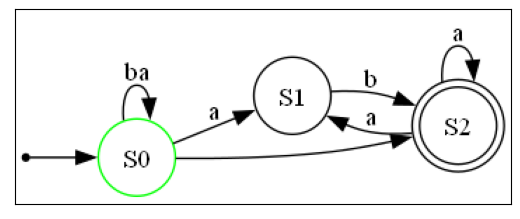

In [4]:
automate = Automate(
    X={"a", "b"},
    S={"S0", "S1", "S2"},
    S0="S0",
    F={"S2"},
    I={
        "S0": {
            "a": {"S1"},
            "ba": {"S0"},
            "": {"S2"},
        },
        "S1": {
            "b": {"S2"},
        },
        "S2": {
            "a": {"S1", "S2"},
        },
    }
)

render(automate)

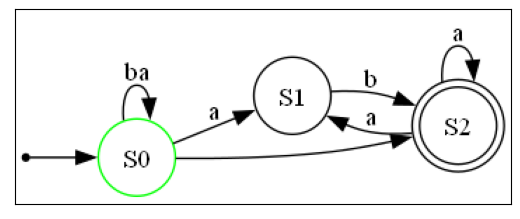

In [5]:
automate.eliminate_long_words()
render(automate)

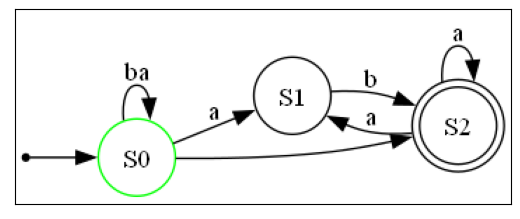

In [6]:
automate.eliminate_empty_words()
render(automate)